# Summary

In [2]:
from epyt import epanet
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
d=epanet("Net1.inp")

EPANET version 20200 loaded (EPyT version 1.1.8).
Input File Net1.inp loaded successfully.



In [4]:
def add_unc(ext, unc):
    # Add uncertainty (unc) to the parameter ext
    ql = [i - unc * i for i in ext]
    qu = [i + unc * i for i in ext]
    rand_list = d.to_array([random.uniform(0, 1) for i in range(len(ext))])
    diff = d.to_array(qu) - d.to_array(ql)
    return d.to_array(ql) + d.multiply_elements(diff, rand_list)

In [5]:
duration=48
step=3600
d.setTimeSimulationDuration(duration*3600)
injection_rate=10 #mg/L
injection_time=[5,20]

In [6]:
quality_type='chem'
quality_units='mg/L'
d.setQualityType(quality_type,quality_units)


In [7]:
d.getNodeCount()

11

In [8]:
Dictionary={}
qunc=0.05
for i in d.getNodeIndex():
    print(f'Scenario:{str(i)}')
    Lengths=add_unc(d.getLinkLength(),qunc)
    Diameters=add_unc(d.getLinkDiameter(),qunc)
    Roughness=add_unc(d.getLinkRoughnessCoeff(),qunc)
    Elevations=add_unc(d.getNodeElevations(),qunc)
    BaseDemand=add_unc(d.getNodeBaseDemands()[1],qunc)
    tmPat=d.Pattern
 
    for k in tmPat:
        Pattern=add_unc(k,qunc)
    d.setLinkLength(Lengths)
    d.setLinkDiameter(Diameters)
    d.setLinkRoughnessCoeff(Roughness)
    d.setNodeElevations(Elevations)
    d.setNodeBaseDemands(BaseDemand)
    d.setPatternMatrix(Pattern)
    d.setTimeQualityStep(step)
    zeronodes=[0]*d.getNodeCount()
    d.setNodeInitialQuality(zeronodes)
    zerolinks=[0]*d.getLinkCount()
    d.setLinkBulkReactionCoeff(zerolinks)
    d.setLinkWallReactionCoeff(zerolinks)
    patlen=int(duration*3600/step)
    tmppat=[0]*int(patlen)
    tmpstartstep=injection_time[0]
    tmpendstep=injection_time[1]
    tmppat[tmpstartstep:tmpendstep]=[1]*(tmpendstep-tmpstartstep)
    tmp1=d.addPattern('Contaminant'+str(i),tmppat)
    tmpinjloc=i
    tmp2=zeronodes
    tmp2[tmpinjloc-1]=tmp1
    d.setNodeSourceType(tmpinjloc,'SETPOINT')
    d.setNodeSourcePatternIndex(tmp2)
    tmp2=zeronodes
    tmp2[tmpinjloc-1]=injection_rate
    d.setNodeSourceQuality(tmp2)
    res=d.getComputedTimeSeries()
    Dictionary[i]=res.NodeQuality


Scenario:1
Scenario:2
Scenario:3
Scenario:4
Scenario:5
Scenario:6
Scenario:7
Scenario:8
Scenario:9
Scenario:10


/home/wahab901278/anaconda3/lib/python3.11/site-packages/epyt/epanet.py:14234: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
/home/wahab901278/anaconda3/lib/python3.11/site-packages/epyt/epanet.py:14234: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Scenario:11


/home/wahab901278/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/wahab901278/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/wahab901278/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


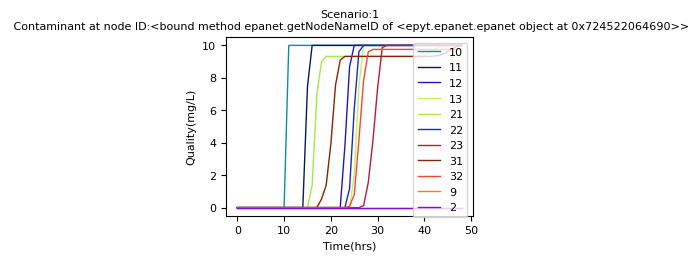

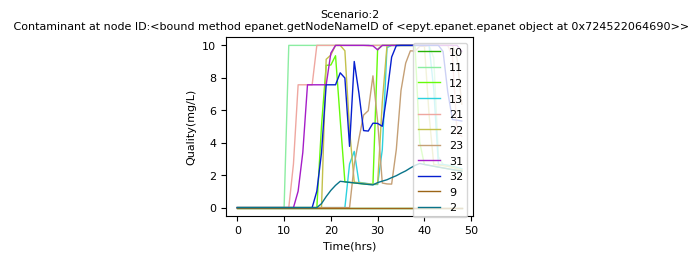

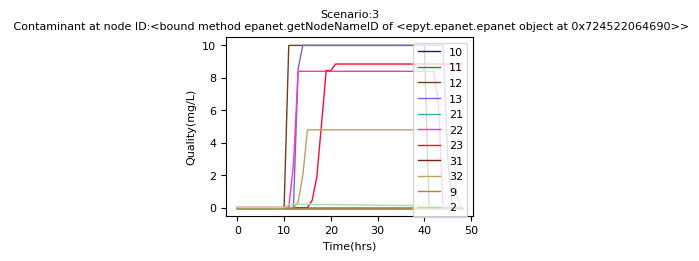

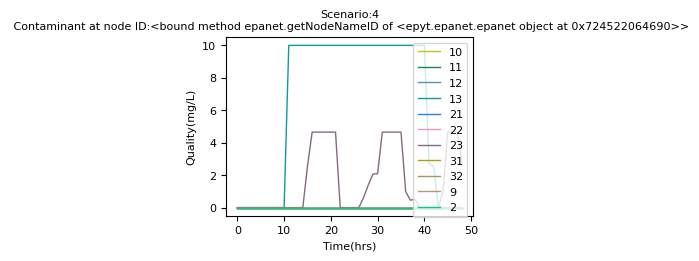

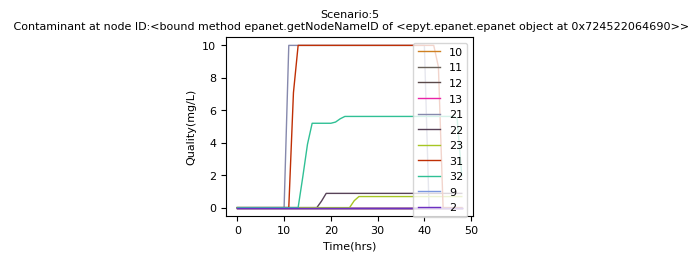

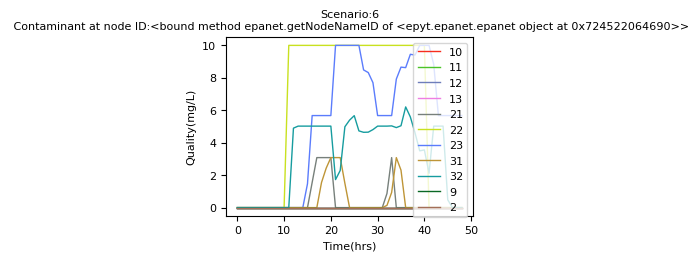

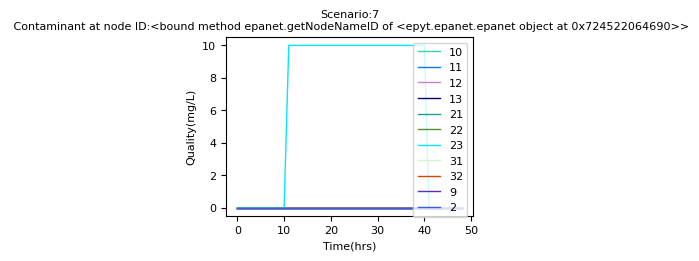

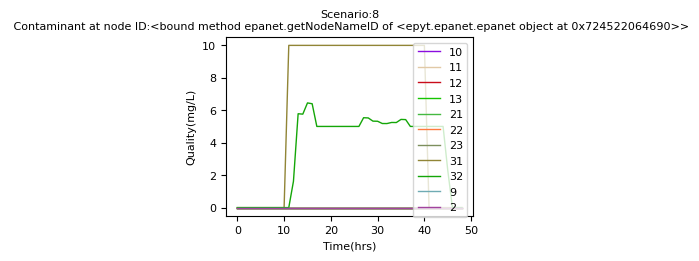

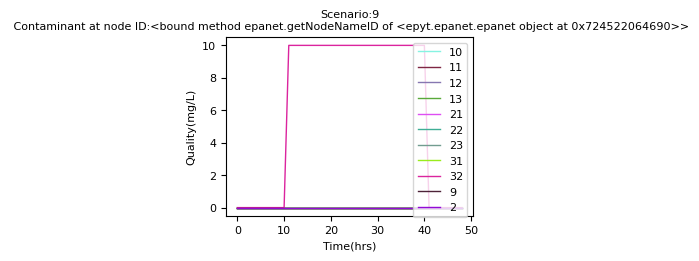

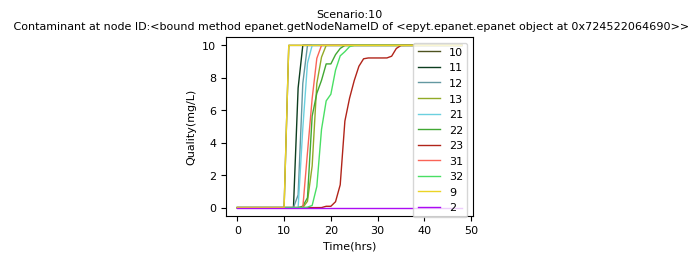

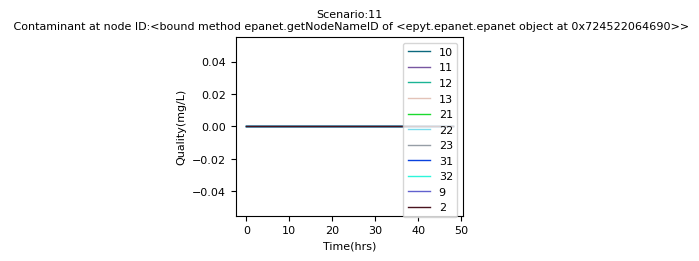

In [9]:
for i in d.getNodeIndex():
    d.plot_ts(Y=Dictionary[i],title=f'Scenario:{str(i)}\n Contaminant at node ID:{d.getNodeNameID}',xlabel='Time(hrs)',ylabel='Quality(mg/L)',color=None,marker=None,fontsize=8,labels=d.getNodeNameID())
    

In [10]:
def analyze_network(inp_file):
    en=epanet(inp_file)
    node_count=en.getNodeCount()
    link_count=en.getLinkCount()
    tank_count=en.getNodeTankCount()
    pump_count=en.getLinkPumpCount()
    valve_count=en.getLinkValveCount()
    
    print(f"Network Summary:")
    print(f"Nodes:{node_count},Links:{link_count}")
    print(f"Tanks:{tank_count},Pumps:{pump_count},Valves:{valve_count}")
    
    elevations=en.getNodeElevations()
    print(f"\n Elevation Statistics:")
    print(f"Min:{min(elevations):.2f},Max:{max(elevations):.2f},Avg:{np.mean(elevations):.2f}")
    
    lengths=en.getLinkLength()
    diameters=en.getLinkDiameter()
    
    print(f"\nPipe Statistics:")
    print(f"Total Length:{np.sum(lengths):.2f}")
    print(f"Avg Diameter:{np.mean(diameters):.2f}")
    step=3600
    d.setTimeHydraulicStep(step)
    d.setTimeQualityStep(step)
    d.setTimeReportingStep(step)
    en.openHydraulicAnalysis()
    en.initializeHydraulicAnalysis(0)
    
    times,pressures,flows=[],[],[]
    
    print("Starting Hydraulic Analysis....")
    
    while step>0:
        t=en.runHydraulicAnalysis()
        times.append(t)
        pressures.append(en.getNodePressure())
        flows.append(en.getLinkFlows())
        print(f"Time step:{t},Pressures:{en.getNodePressure()}")
        step = en.nextHydraulicAnalysisStep()
    en.closeHydraulicAnalysis()
    print(f"Number of time steps:{len(times)}")
    print(f"Shape of pressure array:{np.array(pressures).shape}")
    
    
    if len(flows)>0:
        flows=np.array(flows)
        avg_flows=np.mean(flows,axis=0)
        max_flows=np.max(flows,axis=0)
        min_flows=np.min(flows,axis=0)
        
        print("\n\n Flow Analysis:")
        print(f"Avg Flow:{avg_flows}")
        print(f"Max Flow:{max_flows}")
        print(f"Min Flow:{min_flows}")
    else:
        print(f"\n No data available for the analysis")
        
    if len(pressures)>0:
        pressures=np.array(pressures)
        avg_pressure=np.mean(pressures,axis=0)
        min_pressure=np.min(pressures,axis=0)
        max_pressure=np.max(pressures,axis=0)
        print("\n\n Pressure Analysis:")
        print(f"Avg Pressure:{avg_pressure}")
        print(f"Max Pressure:{max_pressure}")
        print(f"Min Pressure:{min_pressure}")
    else:
        print(f"\n No data available for the analysis")
    
    if len(times)>0 and len(pressures)>0:
        for i in range(min(5,pressures.shape[1])):
            plt.figure(figsize=(10,6))
            plt.plot(times,pressures[:,i],label=f'Node {i+1}')
            plt.xlabel('Time(hours)')
            plt.ylabel('Pressure')
            plt.title('Pressure Variation over time')
            plt.legend()
            plt.grid(True)
            plt.savefig('pressure_variation.png')
            plt.close
    else:
        print(f"\n No data available for the Visualizations")

EPANET version 20200 loaded (EPyT version 1.1.8).
Input File Net1.inp loaded successfully.

Network Summary:
Nodes:11,Links:13
Tanks:1,Pumps:1,Valves:0

 Elevation Statistics:
Min:690.00,Max:850.00,Avg:723.64

Pipe Statistics:
Total Length:63530.00
Avg Diameter:10.15
Starting Hydraulic Analysis....
Time step:0,Pressures:[127.54072571 119.25732422 117.02125549 118.66902161 117.6611557
 118.75815582 120.73696899 115.86077881 110.79018402   0.
  51.99599838]
Time step:3600,Pressures:[128.58963013 120.45028687 118.34940338 119.99139404 118.94074249
 120.07341003 122.05445099 117.14855194 112.08950043   0.
  53.32542419]
Time step:7200,Pressures:[129.24743652 121.1985321  119.63394928 120.91181946 119.3471756
 120.82395172 122.78398132 117.00731659 111.88895416   0.
  54.62432098]
Time step:10800,Pressures:[129.95739746 122.00621033 120.53118896 121.80401611 120.21268463
 121.7090683  123.67070007 117.87722778 112.76452637   0.
  55.52219391]
Time step:14400,Pressures:[130.28079224 122.3741

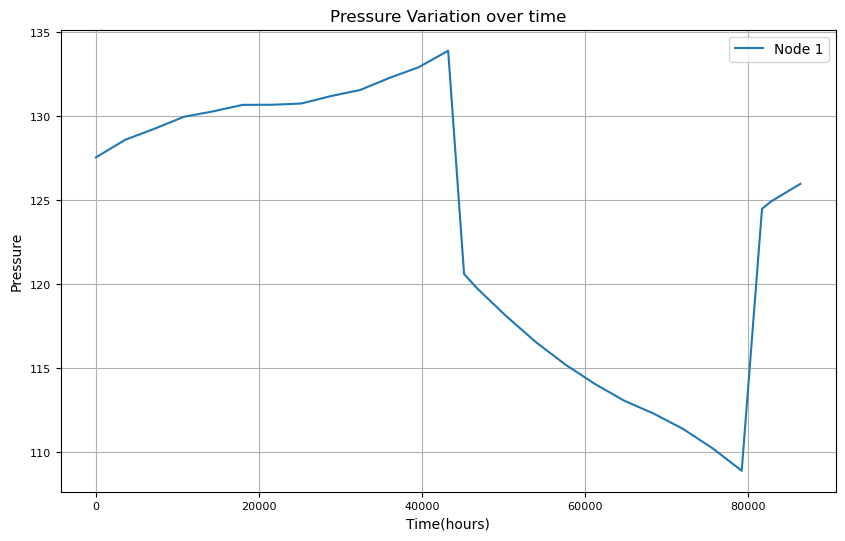

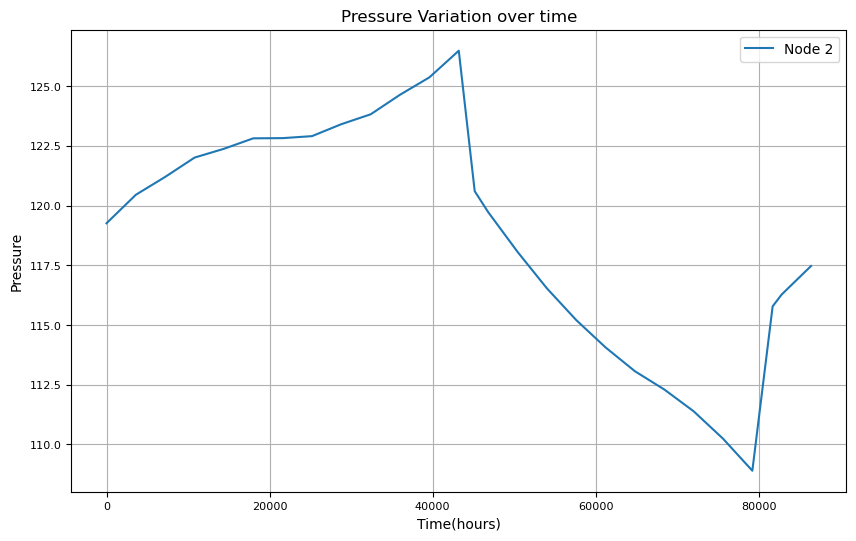

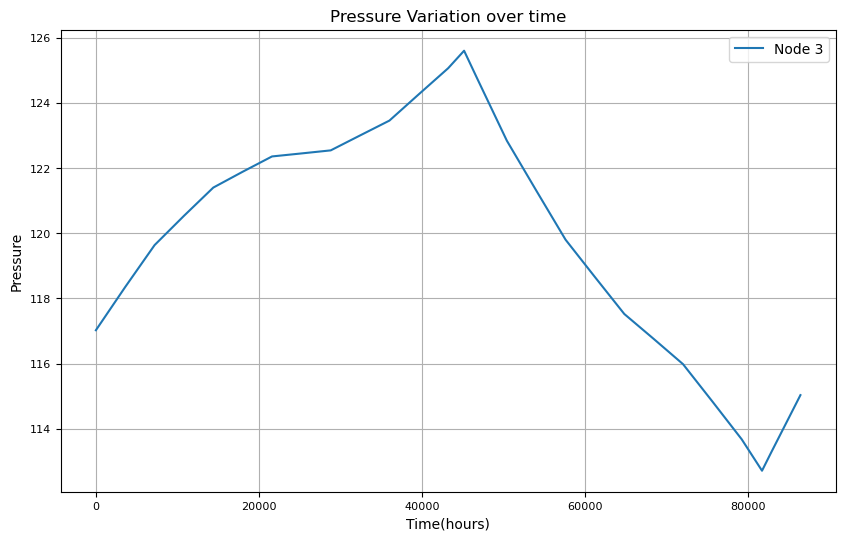

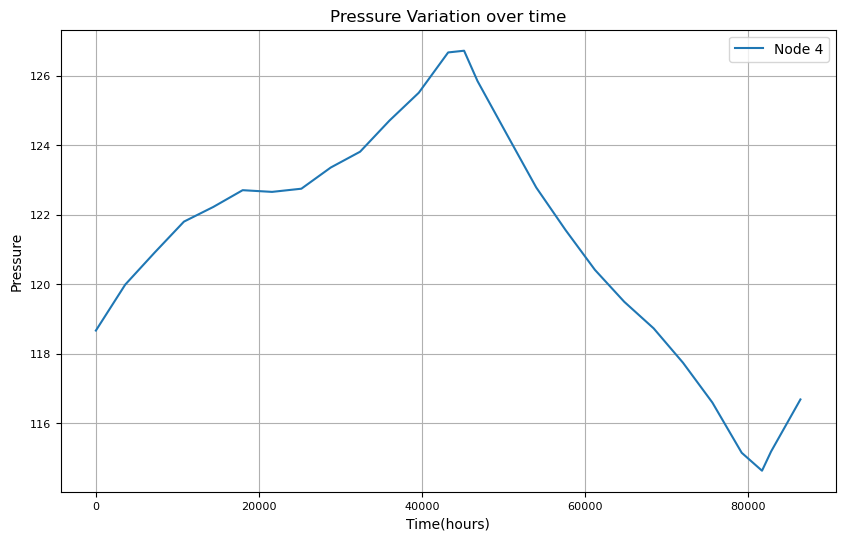

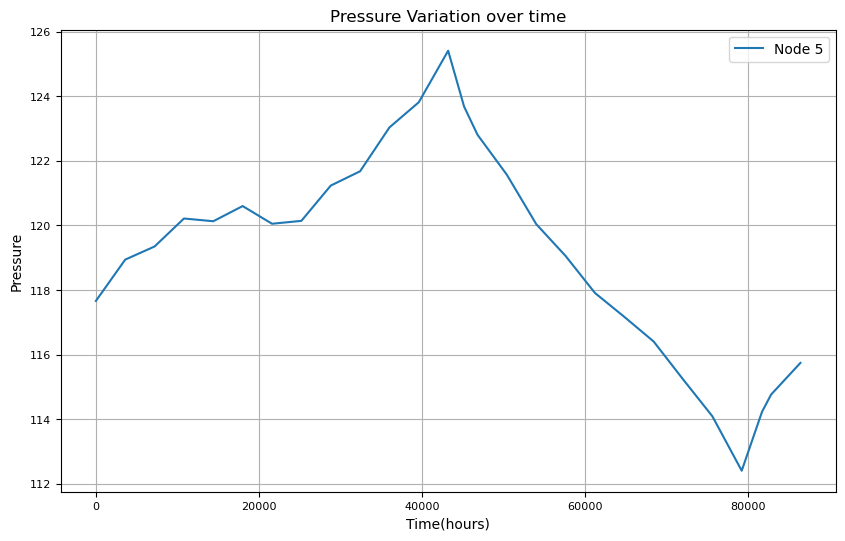

In [11]:
analyze_network('Net1.inp')